# Portfolio Optimization (포트폴리오 최적화)

- 위험회피적 투자자가 시장 위험의 주어진 수준에 따라 기대수익을 최적화하거나 최대화하여 보상 수준을 선택  


- Monte Carlo Simulation 에 의한 최적 포트폴리오 탐색

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import FinanceDataReader as fdr
import korean

In [2]:
start = datetime.datetime(2020,1,1)
end = datetime.datetime(2020,12, 31)

- portfolio 생성

In [3]:
# 종목 코드와 종목명을 리스트로 저장합니다.
# stock_list에는 ('종목 코드', '종목명')의 형태로 데이터가 저장되어 있습니다.
stock_list = [('000990', 'DB하이텍'), ('005930', '삼성전자'), ('016360', '삼성증권'), ('035720', '카카오')]

# 주가 데이터를 저장할 빈 데이터프레임을 생성합니다.
portfolio = pd.DataFrame([])

# stock_list에 있는 종목 코드와 종목명을 이용해 데이터를 반복 처리합니다.
for code, name in stock_list:
    # 종목의 종가 데이터를 FinanceDataReader를 통해 가져옵니다.
    df = fdr.DataReader(code, start, end)
    
    # 만약 데이터프레임(df)이 비어있다면, 해당 종목의 코드를 출력합니다.
    if len(df) == 0:
        print(code, name)
    
    # 종가 데이터를 portfolio 데이터프레임에 열(column)로 추가합니다.
    # concat 함수는 새로운 열을 수평 방향(axis=1)으로 추가합니다.
    portfolio = pd.concat([portfolio, df['Close']], axis=1)

# code_names에는 stock_list에서 종목명(name)만 따로 추출해 저장합니다.
code_names = [name for (code, name) in stock_list]

# portfolio 데이터프레임의 열 이름을 종목명 리스트로 변경합니다.
portfolio.columns = code_names

portfolio.head()

,DB하이텍,삼성전자,삼성증권,카카오
2020-01-02 00:00:00,27900,55200,37850,30609
2020-01-03 00:00:00,27600,55500,38100,30609
2020-01-06 00:00:00,28000,55500,37500,31010
2020-01-07 00:00:00,28000,55800,37800,32114
2020-01-08 00:00:00,28950,56800,37150,32014


- 포트폴리오 각 자산의 일일 log 수익률 생성 (daily log return)

In [4]:
log_ret = np.log(portfolio / portfolio.shift())
log_ret.head()

,DB하이텍,삼성전자,삼성증권,카카오
2020-01-02 00:00:00,NaN,NaN,NaN,NaN
2020-01-03 00:00:00,-0.010811,0.005420,0.006583,0.000000
2020-01-06 00:00:00,0.014389,0.000000,-0.015873,0.013016
2020-01-07 00:00:00,0.000000,0.005391,0.007968,0.034982
2020-01-08 00:00:00,0.033366,0.017762,-0.017345,-0.003119


asset 간의 상관 계수

In [5]:
log_ret.corr()

,DB하이텍,삼성전자,삼성증권,카카오
DB하이텍,1.000000,0.513497,0.353162,0.494775
삼성전자,0.513497,1.000000,0.652664,0.346570
삼성증권,0.353162,0.652664,1.000000,0.239416
카카오,0.494775,0.346570,0.239416,1.000000


## Method 1 - Monte Carlo Simulation

- 가능한 allocation 의 조합을 loop 로 반복하여 최적의 조합 (Highest Sharpe ratio) 을 찾는다.


$$Portfolio \ SR = \frac{(포트폴리오 \ 기대수익률 - 무위험수익률)}{포트폴리오\  기대수익률과 \ 무위험수익률\  공분산의 \ 표준편차}$$ 

$$SR=\frac{R_p - R_f}{\sigma_p}$$ 



위의 자산을 1/4 씩 동일 비중으로 포트폴리오 구성한 경우 portfolio 의 샤프 비율 계산

In [6]:
weights = np.array([0.25, 0.25, 0.25, 0.25])

**포트폴리오의 연간 covariance**

공분산(covariance)은 두 주식의 수익률 변동이 어떻게 관련되어 있는지 측정하는 지표입니다. 이 경우, 공분산은 제곱 단위으로 측정되므로 연간화할 때 제곱근을 사용하지 않고 거래일 수(일반적으로 252일)를 곱합니다.  

np.dot( ..., weights)는 두 배열의 내적을 계산합니다. 연간 공분산 행렬과 각 주식의 비중(weights)을 곱하여 포트폴리오 전체의 공분산을 계산합니다.

In [7]:
# 로그 수익률(log_ret) 데이터에서 연간 공분산 행렬을 계산한 후, 포트폴리오 가중치(weights)와 곱하여 전체 포트폴리오의 공분산을 계산합니다.

# log_ret.cov()는 로그 수익률의 공분산 행렬을 계산합니다.
# * 252는 주식시장이 1년에 252일 거래되기 때문에 연간 공분산을 계산하기 위한 보정입니다.
# np.dot()는 두 배열의 내적을 계산하는 함수로, 연간 공분산 행렬과 포트폴리오 가중치(weights)의 내적을 구합니다.
cov = np.dot(log_ret.cov() * 252, weights)
cov

array([0.16857857, 0.08969351, 0.11430358, 0.09408011])

**포트폴리오의 연간 수익률 계산**

각 주식의 평균 로그 수익률에 그 주식이 포트폴리오에서 차지하는 비중을 곱한 후, 이를 모두 더하여(np.sum) 주식 포트폴리오의 일별 예상 수익률을 얻습니다. 그 후, 이 일별 예상 수익률을 연간화하기 위해 252를 곱합니다. 

In [8]:
# 로그 수익률(log_ret)의 평균 수익률과 가중치(weights)를 곱하여 포트폴리오의 기대 수익률을 계산합니다.
# log_ret.mean()은 각 자산의 평균 로그 수익률을 계산합니다.
# * weights는 각 자산에 할당된 가중치를 반영하여 가중합을 구합니다.
# * 252는 주식시장이 1년에 252일 거래되기 때문에, 일간 수익률을 연간 수익률로 변환하기 위한 보정입니다.
ret = np.sum(log_ret.mean() * weights) * 252
ret

0.5077819881560465

**포트폴리오의 연간 변동성 계산**

'np.dot(weights.T, cov)'는 가중치 벡터와 공분산 행렬의 내적을 계산하는 것으로, 이 값은 포트폴리오의 분산을 나타냅니다.

이 분산 값에 'np.sqrt' 함수를 적용하여 포트폴리오의 표준편차(또는 변동성)을 계산합니다. 이 값은 포트폴리오의 위험을 나타내며, 값이 클수록 포트폴리오의 위험이 크다는 것을 의미합니다.

In [9]:
# 포트폴리오의 연간 변동성(위험)을 계산합니다.
# weights.T는 포트폴리오 가중치 벡터의 전치 행렬(transpose)입니다.
# np.dot(weights.T, cov)은 포트폴리오 가중치와 공분산 행렬(cov)의 내적을 계산하여 포트폴리오의 분산을 구합니다.
# np.sqrt()는 이 값을 제곱근으로 변환하여 포트폴리오의 변동성(volatility, vol)을 계산합니다.
vol = np.sqrt(np.dot(weights.T, cov))
vol

0.34156103832575646

**포트폴리오의 샤프지수**

In [10]:
# 포트폴리오의 수익률 대비 변동성 비율을 계산
# ret은 포트폴리오의 연간 기대 수익률을 의미하고, vol은 포트폴리오의 연간 변동성(위험)을 의미
# ret / vol은 변동성(위험) 한 단위당 기대 수익률을 나타내며, 이는 포트폴리오의 효율성을 평가하는 지표로 사용됩니다.
performance_ratio = ret / vol

# 수익률 대비 변동성 비율을 출력합니다.
performance_ratio

1.4866507920372358

### 모든 내용을 집합하여 샤프비율 계산 함수 작성
    반환값 - 연간 기대 수익률, 연간 covariance, sharp ratio 반환 

In [11]:
def get_ret_vol_sr(weights, log_ret):
    """
    parameter : 각 asset의 가중치 list, 로그 수익률
    """
    # 가중치를 numpy array로 변환
    weights = np.array(weights)
    
    # 각 주식의 로그 수익률에 대한 공분산을 계산하고, 가중치를 곱한 후 연간화
    cov = np.dot(log_ret.cov() * 252, weights)
    
    # 각 주식의 평균 로그 수익률에 가중치를 곱한 후 합산하여 포트폴리오의 일별 예상 수익률을 구하고, 이를 연간화
    ret = np.sum(log_ret.mean() * weights) * 252
    
    # 포트폴리오의 분산을 계산한 후, 이의 제곱근을 구하여 포트폴리오의 변동성(표준편차)를 계산
    vol = np.sqrt(np.dot(weights.T, cov))
    
    # 포트폴리오의 수익률을 변동성으로 나누어 샤프 지수를 계산
    sr = ret / vol
    
    # 수익률, 변동성, 샤프 지수를 원소로 하는 numpy array를 반환
    return np.array([ret, vol, sr])

In [12]:
get_ret_vol_sr(weights, log_ret)

array([0.50778199, 0.34156104, 1.48665079])

**MC Simulation - 각 자산의 비중을 무작위로 선택하여 특정 자산 비중에서의 연간 수익률, 변동성, 샤프비율 계산**

주어진 주식 포트폴리오에 대해 각각 랜덤한 가중치를 할당하여 해당 가중치에서의 예상 수익률, 변동성, 샤프 지수를 계산하고, 이를 각각의 배열에 저장하는 과정을 반복적으로 수행합니다. 이렇게 하면 랜덤한 가중치 조합에 대한 포트폴리오 성능을 시뮬레이션하여 최적의 포트폴리오를 탐색하는 데 도움이 됩니다.

In [13]:
# 랜덤 시드 설정
np.random.seed(101)

# 주식의 개수를 구합니다.
cols = len(log_ret.columns)

# 반복 횟수 설정
iteration = 50_000

# 결과를 저장할 배열 초기화
all_weights = np.zeros((iteration, cols))  # 각 반복에서의 가중치 저장
ret_arr = np.zeros(iteration)  # 각 반복에서의 예상 수익률 저장
vol_arr = np.zeros(iteration)  # 각 반복에서의 변동성 저장
sharpe_arr = np.zeros(iteration)  # 각 반복에서의 샤프 지수 저장

# 반복 수만큼 시뮬레이션
for i in range(iteration):
    # 각 주식에 대한 가중치를 랜덤하게 생성
    weights = np.random.random(cols) 
    
    # 가중치의 합이 1이 되도록 스케일링
    weights = weights / np.sum(weights)
    
    # 이번 반복에서의 가중치 저장
    all_weights[i, :] = weights  
    
    # 주어진 가중치에서의 수익률, 변동성, 샤프 지수 계산
    rvs = get_ret_vol_sr(weights, log_ret) 
    
    # 결과 저장
    ret_arr[i] = rvs[0]  # 수익률 저장
    vol_arr[i] = rvs[1]  # 변동성 저장
    sharpe_arr[i] = rvs[2]  # 샤프 지수 저장

In [14]:
sharpe_arr.shape

(50000,)

In [15]:
sharpe_arr

array([1.46645523, 1.76652878, 1.27942786, ..., 1.55566596, 1.40503513,
       1.37748793])

- 최적 샤프 비율 (highest sharpe ratio)을 구하고, 그 때의 최적 자산 배분 비율을 구함

In [16]:
# MC method 에 의해 simulation 한 최적 sharpe ratio
print('최적 Sharpe Ratio = {}'.format(sharpe_arr.max()))

max_idx = sharpe_arr.argmax()
max_idx

최적 Sharpe Ratio = 2.3860838689567987


13988

최적 Sharpe ratio 일 때의 daily return 과 volatility, 최적 portfolio 비율

In [17]:
print('return = {}'.format(ret_arr[max_idx]))
print('volatility = {}'.format(vol_arr[max_idx]))

with np.printoptions(precision=5, suppress=True):
    print('최적 자산 배분 비율 = {} : {}'.format(log_ret.columns.values, all_weights[max_idx]))

return = 0.8642663867488267
volatility = 0.36221123573778063
최적 자산 배분 비율 = ['DB하이텍' '삼성전자' '삼성증권' '카카오'] : [0.00079 0.16159 0.00088 0.83674]


- 포트폴리오 조합 및 최적 포트폴리오 시각화

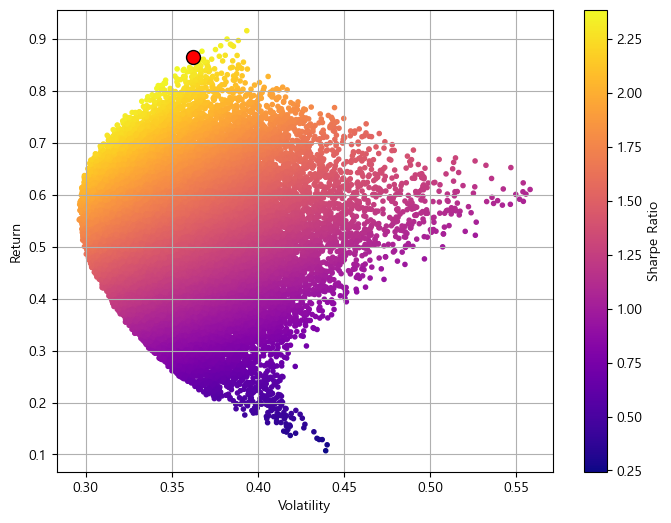

In [18]:
plt.figure(figsize=(8, 6))

# 포트폴리오의 변동성(vol_arr)과 수익률(ret_arr)을 산점도로 시각화합니다.
# c=sharpe_arr는 샤프 비율 배열을 색으로 사용하여 각 포트폴리오의 효율성을 시각적으로 나타냅니다.
# marker='.'는 점으로 표시, cmap='plasma'는 색상 팔레트를 설정합니다.
plt.scatter(vol_arr, ret_arr, c=sharpe_arr, marker='.', cmap='plasma')

# 색상 바를 추가하여 샤프 비율(Sharpe Ratio)을 시각적으로 표시합니다.
plt.colorbar(label='Sharpe Ratio')

# 그리드를 추가하여 그래프를 보기 쉽게 만듭니다.
plt.grid(True)

# x축 레이블을 'Volatility'(변동성)으로 설정합니다.
plt.xlabel('Volatility')

# y축 레이블을 'Return'(수익률)으로 설정합니다.
plt.ylabel('Return')

# 최적의 포트폴리오를 표시합니다.
# 최적 포트폴리오는 샤프 비율이 가장 높은 포트폴리오로, 그 좌표(vol_arr[max_idx], ret_arr[max_idx])를 빨간색 원('ro')으로 표시합니다.
# markeredgecolor='k'는 마커의 테두리를 검은색으로 설정, markersize=10은 마커의 크기를 10으로 설정합니다.
plt.plot(vol_arr[max_idx], ret_arr[max_idx], 'ro', markeredgecolor='k', markersize=10)